# A* Algorithm

## In short

The A* algorithm is an informed search method that uses a heuristic function to find the shortest path in a weighted graph to the goal. This function guesses how much it will cost to reach the goal from each point, helping the algorithm focus on better options and skip unhelpful paths.

## How it works

Imagine you're finding the shortest route between two cities. Dijkstra's algorithm checks all paths, while Best-First Search heads directly to the destination, possibly missing shortcuts. The A* algorithm combines the best of both — it looks at:

1. The distance already traveled from the start
2. A smart estimate of the remaining distance to the goal

## A* algorithm cost function

![Picture - A* algorithm Cost Function](https://media.datacamp.com/cms/google/ad_4nxdurjsqymkb8cxyk0jl0tq0m82pqowydssekbtc4ltysic-tp59lttv22izzlvnfqowfcodbanjb2l6fzpbf7akwmplmogbav8o3norwakys9ayugjoq-v32fmpiw3khvokhnuvxa.jpeg)

### Path cost $g(n)$

The path cost function, $g(n)$, is the exact distance from the starting point to the current position in the search. Unlike estimated values, this parameter is accurate and is found by adding up all the edge weights traveled along the chosen path.

### Heuristic function $h(n)$

The heuristic function, $h(n)$, gives an estimated cost from the current vertex to the goal, serving as the algorithm's "informed guess" for the remaining distance. To ensure it never overestimates the true cost: $(h(n) \leqslant h^*(n))$ for any $n$, where $h^*(n)$ is the actual cost to the goal. In grid-based or map problems, typical heuristic methods include Manhattan and Euclidean distance.

### Total estimated cost $f(n)$

$f(n)$ determines the algorithm next move. It combines the actual path cost $g(n)$ and the heuristic estimate $h(n)$. The algorithm picks the vertex with the smallest $f(n)$ value from the open list, balancing what is already known about the path with estimated remaining distances. For any vertex $n$:

$$f(n) = g(n) + h(n)$$

## Open & closed lists

The A* algorithm uses two key lists:

**Open list**:  
- Holds vertices to be evaluated.
- Sorted by $f(n)$ value (lowest first).
- New vertices are added as they are discovered.

**Closed list**:  
- Stores vertices that have already been evaluated.
- Prevents re-evaluating vertices.
- Assists in reconstructing the final path.

The algorithm keeps picking the vertex with the smallest $f(n)$ from the open list, processes it, and moves it to the closed list. This continues until the goal is reached or no path is found.

---

# Example

A* algorithm implementation on a 2D grid (for better visualization) -> simple graph with equal weights = 1.

In [153]:
from typing import List, Tuple, Dict
import numpy as np
import heapq
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
def create_vertex(position: Tuple[int, int], g: float = float('inf'), 
                h: float = 0.0, parent: Dict = None) -> Dict:
    """
    Create a vertex for the A* algorithm.
    
    Args:
        position: (x, y) coordinates of the vertex
        g: Cost from start to this vertex (default: infinity)
        h: Estimated cost from this vertex to goal (default: 0)
        parent: Reference to the previous vertex (default: None)
    
    Returns:
        Dictionary containing vertex information
    """
    return {
        'position': position,
        'g': g,
        'h': h,
        'f': g + h,
        'parent': parent
    }

In [156]:
def calculate_heuristic(pos1: Tuple[int, int], pos2: Tuple[int, int]) -> float:
    """
    Calculate the estimated distance between two points using Euclidean distance.
    It is admissible because diagonal movement is allowed. 
    It provides straight-line distance to the goal, which is the minimum possible travel cost.
    """
    x1, y1 = pos1
    x2, y2 = pos2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [157]:
def get_valid_neighbors(grid: np.ndarray, position: Tuple[int, int]) -> List[Tuple[int, int]]:
    """
    Get all valid neighboring positions in the grid.
    
    Args:
        grid: 2D numpy array where 0 represents walkable cells and 1 represents obstacles
        position: Current position (x, y)
    
    Returns:
        List of valid neighboring positions
    """
    x, y = position
    rows, cols = grid.shape
    
    # All possible moves
    possible_moves = [
        (x+1, y), (x-1, y),      # Right, Left
        (x, y+1), (x, y-1),      # Up, Down
        (x+1, y+1), (x-1, y-1),  # Diagonal moves
        (x+1, y-1), (x-1, y+1)
    ]
    
    return [
        (nx, ny) for nx, ny in possible_moves
        if 0 <= nx < rows and 0 <= ny < cols  # Within grid bounds
        and grid[nx, ny] == 0                 # Not an obstacle
    ]

In [158]:
def reconstruct_path(goal_vertex: Dict) -> List[Tuple[int, int]]:
    """
    Reconstruct the path from goal to start by following parent pointers.
    """
    path = []
    current = goal_vertex
    
    while current is not None:
        path.append(current['position'])
        current = current['parent']
        
    return path[::-1]  # Reverse to get path from start to goal

In [159]:
def a_star_main(grid: np.ndarray, start: Tuple[int, int], goal: Tuple[int, int]) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    """
    Find the optimal path using A* algorithm.
    
    Args:
        grid: 2D numpy array (0 = free space, 1 = obstacle)
        start: Starting position (x, y)
        goal: Goal position (x, y)
    
    Returns:
        Tuple containing:
        - List of positions (vertices) representing the optimal path
        - List of additional points processed during the search
    """
    # Initialize start vertex
    start_vertex = create_vertex(
        position=start,
        g=0,
        h=calculate_heuristic(start, goal)
    )
    
    # Initialize open and closed sets
    open_list = [(start_vertex['f'], start)]  # Priority queue
    open_dict = {start: start_vertex}         # For quick vertex lookup
    closed_set = set()                        # Explored vertices
    add_points = []                           # Additional points processed
    
    while open_list:
        # Get vertex with lowest f value
        _, current_pos = heapq.heappop(open_list)
        current_vertex = open_dict[current_pos]
        print("Current vertex:", current_pos)
        add_points.append(current_pos)
        
        # Check if we've reached the goal
        if current_pos == goal:
            return reconstruct_path(current_vertex), add_points

        closed_set.add(current_pos)
        
        # Explore neighbors
        for neighbor_pos in get_valid_neighbors(grid, current_pos):
            print("Neighbor", neighbor_pos)
            add_points.append(neighbor_pos)
            # Skip if already explored
            if neighbor_pos in closed_set:
                continue
                
            # Calculate cost to move from the start vertex to the neighbor via the current vertex
            tentative_g = current_vertex['g'] + calculate_heuristic(current_pos, neighbor_pos)

            # Create or update neighbor
            if neighbor_pos not in open_dict:
                neighbor = create_vertex(
                    position=neighbor_pos,
                    g=tentative_g,
                    h=calculate_heuristic(neighbor_pos, goal),
                    parent=current_vertex
                )
                # Add the neighbor to open list
                heapq.heappush(open_list, (neighbor['f'], neighbor_pos))
                open_dict[neighbor_pos] = neighbor
                
            # If the neighbor is already in the open list but has a better path
            elif tentative_g < open_dict[neighbor_pos]['g']:
                # Update neighbor
                neighbor = open_dict[neighbor_pos]
                neighbor['g'] = tentative_g
                neighbor['f'] = tentative_g + neighbor['h']
                neighbor['parent'] = current_vertex
    
    return [], add_points  # No path found

In [160]:
def visualize_path(grid: np.ndarray, path: List[Tuple[int, int]], add_points: List[Tuple[int, int]]):
    """
    Visualize the grid and found path.
    """
    plt.figure(figsize=(8, 8))
    
    if path:
        path_np = np.array(path)
        plt.plot(path_np[:, 0], path_np[:, 1], 'b-', linewidth=3, label='Path')
        plt.plot(path_np[0, 0], path_np[0, 1], 'go', markersize=20, label='Start')
        plt.plot(path_np[-1, 0], path_np[-1, 1], 'ro', markersize=20, label='Goal')
        
        point_counts = {}
        for i, point in enumerate(add_points):
            if point in point_counts:
                point_counts[point].append(i + 1)
            else:
                point_counts[point] = [i + 1]
        
        processing_order_label_added = False
        processed_many_times_label_added = False
        
        for point, indices in point_counts.items():
            if len(indices) > 1:
                plt.scatter(point[0], point[1], color='black', s=250, 
                            label='Processed Many Times' if not processed_many_times_label_added else "")
                processed_many_times_label_added = True
            else:
                plt.scatter(point[0], point[1], facecolors="none", 
                            edgecolors='black', s=250,
                            label='Processing Order' if not processing_order_label_added else "")
                plt.text(point[0], point[1], str(indices[0]), color='black', fontsize=10, ha='center', va='center')
                processing_order_label_added = True
    
    plt.grid(True)
    plt.xticks([i for i in range(1, grid.shape[0] + 1)])
    plt.yticks([i for i in range(grid.shape[1] + 1)])
    plt.gca().invert_yaxis()  # Invert y-axis to match the grid indexing
    plt.xlim(0, grid.shape[0])
    plt.ylim(0, grid.shape[1])
    plt.legend(fontsize=12, loc='lower left', handletextpad=1, labelspacing=1)
    plt.title("A* Pathfinding Result")
    plt.show()

Current vertex: (3, 3)
Neighbor (4, 3)
Neighbor (2, 3)
Neighbor (3, 4)
Neighbor (3, 2)
Neighbor (4, 4)
Neighbor (2, 2)
Neighbor (4, 2)
Neighbor (2, 4)
Current vertex: (4, 2)
Neighbor (5, 2)
Neighbor (3, 2)
Neighbor (4, 3)
Neighbor (4, 1)
Neighbor (5, 3)
Neighbor (3, 1)
Neighbor (5, 1)
Neighbor (3, 3)
Current vertex: (5, 1)

Path found with 3 steps!


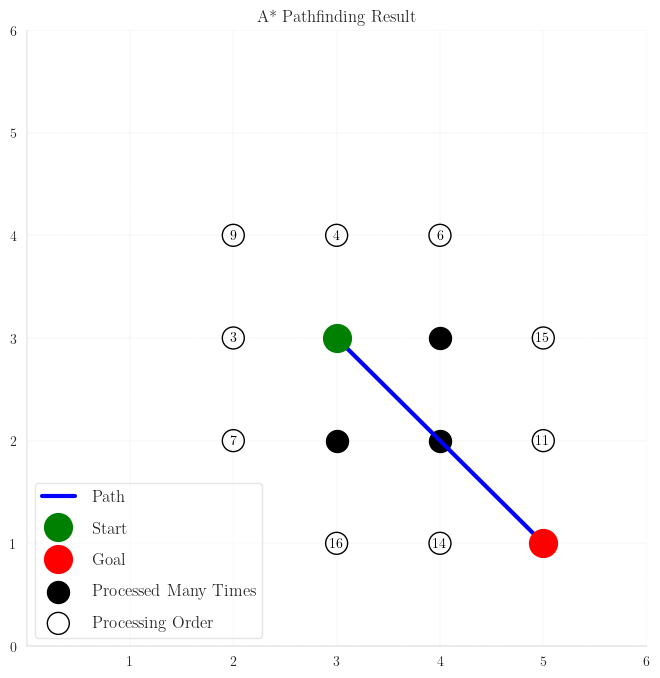

In [161]:
# Create a sample grid
grid = np.zeros((6, 6))

# Add some obstacles
# grid[5:15, 10] = 1
# grid[5, 5:15] = 1
# grid[15, 5:15] = 1

# grid[4, 2:5] = 1
# grid[2:5, 2] = 1
# grid[2, 2:5] = 1
# grid[2:5, 4] = 1

# Define start and goal positions
start_pos = (3, 3)
goal_pos = (5, 1)

# Find the path
path, add_points = a_star_main(grid, start_pos, goal_pos)
if path:
    print(f"\nPath found with {len(path)} steps!")
    visualize_path(grid, path, add_points)
else:
    print("\nNo path found!")
    visualize_path(grid, path, add_points)

In [162]:
# order of vertices processed
add_points

[(3, 3),
 (4, 3),
 (2, 3),
 (3, 4),
 (3, 2),
 (4, 4),
 (2, 2),
 (4, 2),
 (2, 4),
 (4, 2),
 (5, 2),
 (3, 2),
 (4, 3),
 (4, 1),
 (5, 3),
 (3, 1),
 (5, 1),
 (3, 3),
 (5, 1)]

---